<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Supercharge_your_Training_with_Pytorch_Lightning_and_Weights_and_Biases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<!--- @wandbcode{lit_colab} -->

<img src="https://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />

<!--- @wandbcode{lit_colab} -->

# ⚡ 💘 🏋️‍♀️ Supercharge your Training with PyTorch Lightning + Weights & Biases

<img src="https://wandb.me/mini-diagram" width="650" alt="Weights & Biases" />

At Weights & Biases, we love anything
that makes training deep learning models easier.
That's why we worked with the folks at PyTorch Lightning to
[integrate our experiment tracking tool](https://docs.wandb.com/library/integrations/lightning)
directly into
[the Lightning library](https://pytorch-lightning.readthedocs.io/en/latest/common/loggers.html#weights-and-biases).

[PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/stable/) is a lightweight wrapper for organizing your PyTorch code and easily adding advanced features such as distributed training and 16-bit precision.
It retains all the flexibility of PyTorch,
in case you need it,
but adds some useful abstractions
and builds in some best practices.

## What this notebook covers:

1. Differences between PyTorch and PyTorch Lightning, including how to set up `LightningModules` and `LightningDataModules`
2. How to get basic metric logging with the [`WandbLogger`](https://pytorch-lightning.readthedocs.io/en/latest/common/loggers.html#weights-and-biases)
3. How to log media with W&B and fully customize logging with Lightning `Callbacks`

## The interactive dashboard in W&B will look like this:

![](https://i.imgur.com/lIbMyFR.png)

## Follow along with a [video tutorial](http://wandb.me/lit-video)!

# 🚀 Installing and importing

`wandb` and `pytorch-lightning` are both easily installable via [`pip`](https://pip.pypa.io/en/stable/).

In [ ]:
!pip install -qqq wandb pytorch-lightning torchmetrics

PyTorch Lightning is built on top of PyTorch,
so we still need to import vanilla PyTorch.

In [ ]:
# numpy for non-GPU array math
import numpy as np

# 🍦 Vanilla PyTorch
import torch
from torch.nn import functional as F
from torch import nn
from torch.utils.data import DataLoader, random_split

# 👀 Torchvision for CV
from torchvision.datasets import MNIST
from torchvision import transforms

# remove slow mirror from list of MNIST mirrors
MNIST.mirrors = [mirror for mirror in MNIST.mirrors
                 if not mirror.startswith("http://yann.lecun.com")]

Much of Lightning is built on the [Modules](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)
API from PyTorch,
but adds extra features
(like data loading and logging)
that are common to lots of PyTorch projects.

Let's bring those in,
plus W&B and the integration.

Lastly, we log in to the [Weights & Biases web service](https://wandb.ai).
If you've never used W&B,
you'll need to sign up first.
Accounts are free forever for academic and public projects.

In [ ]:
# ⚡ PyTorch Lightning
import pytorch_lightning as pl
import torchmetrics
pl.seed_everything(hash("setting random seeds") % 2**32 - 1)

# 🏋️‍♀️ Weights & Biases
import wandb

# ⚡ 🤝 🏋️‍♀️
from pytorch_lightning.loggers import WandbLogger

wandb.login()

> _Note_: If you're executing your training in a terminal, rather than a notebook, you don't need to include `wandb.login()` in your script.
Instead, call `wandb login` in the terminal and we'll keep you logged in for future runs.

# 🏗️ Building a Model with Lightning

In PyTorch Lightning, models are built with `LightningModule` ([docs here](https://pytorch-lightning.readthedocs.io/en/latest/lightning_module.html)), which has all the functionality of a vanilla `torch.nn.Module` (🍦) but with a few delicious cherries of added functionality on top (🍨).
These cherries are there to cut down on boilerplate and
help separate out the ML engineering code
from the actual machine learning.

For example, the mechanics of iterating over batches
as part of an epoch are extracted away,
so long as you define what happens on the `training_step`.

To make a working model out of a `LightningModule`,
we need to define a new `class` and add a few methods on top.

We'll demonstrate this process with `LitMLP`,
which applies a two-layer perceptron
(aka two fully-connected layers and
a fully-connected softmax readout layer)
to input `Tensors`.

> _Note_: It is common in the Lightning community to shorten "Lightning" to "[Lit](https://www.urbandictionary.com/define.php?term=it%27s%20lit)".
This sometimes it sound like
[your code was written by Travis Scott](https://www.youtube.com/watch?v=y3FCXV8oEZU).
We consider this a good thing.

## 🍦 `__init__` and `forward`

First, we need to add two methods that
are part of any vanilla PyTorch model.

Those methods are:
* `__init__` to do any setup, just like any Python class
* `forward` for inference, just like a PyTorch Module


The `forward` pass method is standard,
and it'll be different for every project,
so we won't comment on it.

The `__init__` method,
which `init`ializes new instances of the class,
is a good place to log hyperparameter information to `wandb`.

This is done with the `save_hyperparameters` method,
which captures all of the arguments to the initializer
and adds them to a dictionary at `self.hparams` --
that all comes for free as part of the `LightningModule`.

> _Note_: `hparams` is logged to `wandb` as the `config`,
so you'll never lose track of the arguments you used to run a model again!

In [ ]:
class LitMLP(pl.LightningModule):

    def __init__(self, in_dims, n_classes=10,
                 n_layer_1=128, n_layer_2=256, lr=1e-4):
        super().__init__()

        # we flatten the input Tensors and pass them through an MLP
        self.layer_1 = nn.Linear(np.prod(in_dims), n_layer_1)
        self.layer_2 = nn.Linear(n_layer_1, n_layer_2)
        self.layer_3 = nn.Linear(n_layer_2, n_classes)

        # log hyperparameters
        self.save_hyperparameters()

        # compute the accuracy -- no need to roll your own!
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()

    def forward(self, x):
        """
        Defines a forward pass using the Stem-Learner-Task
        design pattern from Deep Learning Design Patterns:
        https://www.manning.com/books/deep-learning-design-patterns
        """
        batch_size, *dims = x.size()

        # stem: flatten
        x = x.view(batch_size, -1)

        # learner: two fully-connected layers
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        
        # task: compute class logits
        x = self.layer_3(x)
        x = F.log_softmax(x, dim=1)

        return x

    # convenient method to get the loss on a batch
    def loss(self, xs, ys):
        logits = self(xs)  # this calls self.forward
        loss = F.nll_loss(logits, ys)
        return logits, loss

> _Note_: for pedagogical purposes, we're splitting out
each stage of building the `LitMLP` into a different cell.
In a more typical workflow,
this would all happen in the `class` definition.

> _Note_: if you're familiar with PyTorch,
you might be surprised to see we aren't taking care with `.device`s:
no `to_cuda` etc. PyTorch Lightning handles all that for you! 😎

## 🍨 `training_step` and `configure_optimizers`
Now, we add some special methods so that our `LitMLP` can be trained
using PyTorch Lightning's training API.

> _Note_: if you've used Keras, this might be familiar.
It's very similar to the `.fit` API in that library.

Those methods are

* `training_step`, which takes a batch and computes the loss; backprop goes through it
* `configure_optimizers`, which returns the `torch.optim.Optimizer` to apply after the `training_step`

> _Note_: `training_step` is part of a rich system of callbacks in PyTorch Lightning.
These callbacks are methods that get called
at specific points during training
(e.g. when a validation epoch ends),
and they are a major part of what makes
PyTorch Lightning both useful and extensible.

Here's where we add some more serious logging code.
`self.log` takes a name and value for a metric.
Under the hood, this will get passed to `wandb.log` if you're using W&B.

The logging behavior of PyTorch Lightning is both intelligent and configurable.
For example, by passing the `on_epoch`
keyword argument here,
we'll get `_epoch`-wise averages
of the metrics logged on each `_step`,
and those metrics will be named differently
in the W&B interface.
When training in a distributed setting,
these averages will be automatically computed across nodes.

Read more about the `log` method [in the docs](https://pytorch-lightning.readthedocs.io/en/latest/lightning_module.html#log).

In [ ]:
def training_step(self, batch, batch_idx):
    xs, ys = batch
    logits, loss = self.loss(xs, ys)
    preds = torch.argmax(logits, 1)

    # logging metrics we calculated by hand
    self.log('train/loss', loss, on_epoch=True)
    # logging a pl.Metric
    self.train_acc(preds, ys)
    self.log('train/acc', self.train_acc, on_epoch=True)
    
    return loss

def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.hparams["lr"])

LitMLP.training_step = training_step
LitMLP.configure_optimizers = configure_optimizers

## ➕ Optional methods for even better logging

The code above will log our model's performance,
system metrics, and more to W&B.

If we want to take our logging to the next level,
we need to make use of PyTorch Lightning's callback system.

> _Note_: thanks to the clean design of PyTorch Lightning,
the training code below will run with or without any
of this extra logging code. Nice!

The other callbacks we'll make use of fall into two categories:
* methods that trigger on each batch for a dataset: `validation_step` and `test_step`
* methods that trigger at the end of an epoch,
or a full pass over a given dataset: `{training, validation, test}_epoch_end`

### 💾 `test`ing and saving the model

We use the test set to evaluate the performance of the final model,
so the `test` callbacks will be called at the end of the training pipeline.

For performance on the `test` and `validation` sets,
we're typically less concerned about how
we do on intermediate steps and more
with how we did overall.
That's why below, we pass in
`on_step=False` and `on_epoch=True`
so that we log only `epoch`-wise metrics.

> _Note_: That's actually the default behavior for `.log` when it's called inside of a `validation` or a `test` loop -- but not when it's called inside a `training` loop! Check out the table of default behaviors for `.log` [in the docs](https://pytorch-lightning.readthedocs.io/en/latest/lightning_module.html#log).

In [ ]:
def test_step(self, batch, batch_idx):
    xs, ys = batch
    logits, loss = self.loss(xs, ys)
    preds = torch.argmax(logits, 1)

    self.test_acc(preds, ys)
    self.log("test/loss_epoch", loss, on_step=False, on_epoch=True)
    self.log("test/acc_epoch", self.test_acc, on_step=False, on_epoch=True)

LitMLP.test_step = test_step

We'll also take the opportunity to save the model in the
[portable `ONNX` format](https://onnx.ai/).


Later,
we'll see that this allows us to use the
[Netron model viewer](https://github.com/lutzroeder/netron) in W&B.

In [ ]:
def test_epoch_end(self, test_step_outputs):  # args are defined as part of pl API
    dummy_input = torch.zeros(self.hparams["in_dims"], device=self.device)
    model_filename = "model_final.onnx"
    self.to_onnx(model_filename, dummy_input, export_params=True)
    artifact = wandb.Artifact(name="model.ckpt", type="model")
    artifact.add_file(model_filename)
    wandb.log_artifact(artifact)

LitMLP.test_epoch_end = test_epoch_end

### 📊 Logging `Histograms`

For the `validation_data`,
let's track not only the `acc`uracy and `loss`,
but also the `logits`:
the un-normalized class probabilities.
That way, we can track if our network
is becoming more or less confident over time.

There's a problem though:
`.log` wants to average,
but we'd rather look at a distribution.

So instead, on every `validation_step`,
we'll `return` the `logits`,
rather than `log`ging them.

Then, when we reach the `end`
of the `validation_epoch`,
the `logits` are available as the
`validation_step_outputs` -- a list.

So to log we'll take those `logits`,
concatenate them together,
and turn them into a histogram with [`wandb.Histogram`](https://docs.wandb.com/library/log#histograms).

Because we're no longer using Lightning's `.log` interface and are instead using `wandb`,
we need to drop down a level and use
`self.experiment.logger.log`.

In [ ]:
def validation_step(self, batch, batch_idx):
    xs, ys = batch
    logits, loss = self.loss(xs, ys)
    preds = torch.argmax(logits, 1)
    self.valid_acc(preds, ys)

    self.log("valid/loss_epoch", loss)  # default on val/test is on_epoch only
    self.log('valid/acc_epoch', self.valid_acc)
        
    return logits

def validation_epoch_end(self, validation_step_outputs):
    dummy_input = torch.zeros(self.hparams["in_dims"], device=self.device)
    model_filename = f"model_{str(self.global_step).zfill(5)}.onnx"
    torch.onnx.export(self, dummy_input, model_filename, opset_version=11)
    artifact = wandb.Artifact(name="model.ckpt", type="model")
    artifact.add_file(model_filename)
    self.logger.experiment.log_artifact(artifact)

    flattened_logits = torch.flatten(torch.cat(validation_step_outputs))
    self.logger.experiment.log(
        {"valid/logits": wandb.Histogram(flattened_logits.to("cpu")),
         "global_step": self.global_step})

LitMLP.validation_step = validation_step
LitMLP.validation_epoch_end = validation_epoch_end

Note that we're once again saving
the model in ONNX format.
That way, we can roll back our model to any given epoch --
useful in case the evaluation on the test set reveals we've overfit.

### 📲 `Callback`s for extra-fancy logging

What we've done so far
will tell us how well our model
is using our system resources,
how well our model is training and generalizing,
and how confident it is.

But DNNs often fail in pernicious and silent ways.
Often, the only way to notice these failures
is to look at how the model is doing
on specific examples.

So let's additionally log some detailed information on some specific examples:
the inputs, outputs,
and `pred`ictions.

We'll do this by writing our own `Callback` --
one that, after every `validation_epoch` ends,
logs input images and output predictions
using W&B's `Image` logger.

> _Note_:
For more on the W&B media toolkit, read the [docs](https://docs.wandb.com/library/log#media)
or check out
[this Colab](http://wandb.me/media-colab)
to see everything it's capable of.

In [ ]:
class ImagePredictionLogger(pl.Callback):
    def __init__(self, val_samples, num_samples=32):
        super().__init__()
        self.val_imgs, self.val_labels = val_samples
        self.val_imgs = self.val_imgs[:num_samples]
        self.val_labels = self.val_labels[:num_samples]
          
    def on_validation_epoch_end(self, trainer, pl_module):
        val_imgs = self.val_imgs.to(device=pl_module.device)

        logits = pl_module(val_imgs)
        preds = torch.argmax(logits, 1)

        trainer.logger.experiment.log({
            "examples": [wandb.Image(x, caption=f"Pred:{pred}, Label:{y}") 
                            for x, pred, y in zip(val_imgs, preds, self.val_labels)],
            "global_step": trainer.global_step
            })

# 🛒 Loading data

Data pipelines can be created with:
* 🍦 Vanilla Pytorch `DataLoaders`
* ⚡ Pytorch Lightning `DataModules`

`DataModules` are more structured definition, which allows for additional optimizations such as automated distribution of workload between CPU & GPU.
Using `DataModules` is recommended whenever possible!

A `DataModule` is also defined by an interface:
* `prepare_data` (optional) which is called only once and on 1 GPU -- typically something like the data download step we have below
* `setup`, which is called on each GPU separately and accepts `stage` to define if we are at `fit` or `test` step
* `train_dataloader`, `val_dataloader` and `test_dataloader` to load each dataset

In [ ]:
class MNISTDataModule(pl.LightningDataModule):

    def __init__(self, data_dir='./', batch_size=128):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))])

    def prepare_data(self):
        # download data, train then test
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

        # we set up only relevant datasets when stage is specified
        if stage == 'fit' or stage is None:
            mnist = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist, [55000, 5000])
        if stage == 'test' or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    # we define a separate DataLoader for each of train/val/test
    def train_dataloader(self):
        mnist_train = DataLoader(self.mnist_train, batch_size=self.batch_size)
        return mnist_train

    def val_dataloader(self):
        mnist_val = DataLoader(self.mnist_val, batch_size=10 * self.batch_size)
        return mnist_val

    def test_dataloader(self):
        mnist_test = DataLoader(self.mnist_test, batch_size=10 * self.batch_size)
        return mnist_test

# setup data
mnist = MNISTDataModule()
mnist.prepare_data()
mnist.setup()

# grab samples to log predictions on
samples = next(iter(mnist.val_dataloader()))

# 👟 Making a `Trainer`

The `DataLoader` and the `LightningModule`
are brought together by a `Trainer`,
which orchestrates data loading,
gradient calculation,
optimizer logic,
and logging. 

Luckily, we don't need to sub-class the `Trainer`,
we just need to configure it with keyword arguments.

And that is where we'll use the `pytorch_lightning.loggers.WandbLogger` to connect our logging to W&B.

In [ ]:
wandb_logger = WandbLogger(project="lit-wandb")

> _Note_: Check out [the documentation](https://docs.wandb.com/library/integrations/lightning) for customization options. I like `group`s and `tag`s!.



We can then set up our `Trainer` and customize several options, such as gradient accumulation, half precision training and distributed computing.

We'll stick to the basics for this example,
but half-precision training and easy scaling to distributed settings are two of the major reasons why folks like PyTorch Lightning!

In [ ]:
trainer = pl.Trainer(
    logger=wandb_logger,    # W&B integration
    log_every_n_steps=50,   # set the logging frequency
    gpus=-1,                # use all GPUs
    max_epochs=5,           # number of epochs
    deterministic=True,     # keep it deterministic
    callbacks=[ImagePredictionLogger(samples)] # see Callbacks section
    )

# 🏃‍♀️ Running our Model

Now, let's make it all happen:

In [ ]:
# setup model
model = LitMLP(in_dims=(1, 28, 28))

# fit the model
trainer.fit(model, mnist)

# evaluate the model on a test set
trainer.test(datamodule=mnist,
             ckpt_path=None)  # uses last-saved model

wandb.finish()

> _Note_: In notebooks, we need to call `wandb.finish()` to indicate when we've finished our run. This isn't necessary in scripts.

## Viewing the results on wandb.ai

Among the outputs from W&B,
you will have noticed a few URLs.
One of these is the
[run page](https://docs.wandb.ai/ref/app/pages/run-page),
which has a dashboard with all of the information logged in this run, complete with smart default charts
and more.
The run page is printed both at the start and end of training, and ends with `lit-wandb/runs/{run_id}`.

>_Note_: When visiting your run page, it is recommended to use `global_step` as x-axis to correctly superimpose metrics logged in different stages.



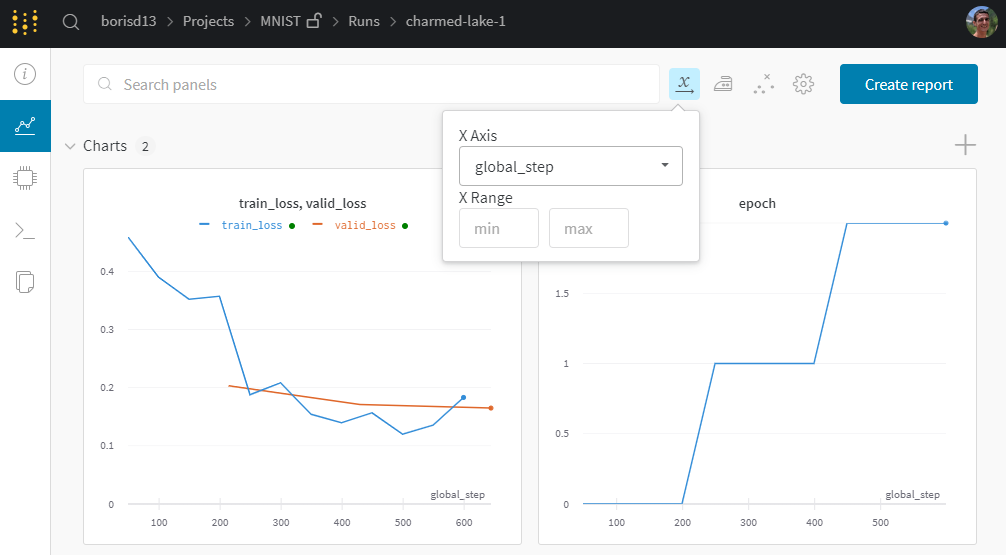